In [1]:
# Cell 1: Imports & reproducibility
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import Tuple

torch.manual_seed(0)
np.random.seed(0)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

def squareplus(x: torch.Tensor) -> torch.Tensor:
    """
    Smooth, always-positive nonlinearity:
    squareplus(x) = 0.5 * (x + sqrt(x^2 + 4)), ~ ReLU but strictly > 0.
    Keeping factors positive makes the KAN product stable.
    """
    return 0.5 * (x + torch.sqrt(x * x + 4.0))


Using device: cuda


In [2]:
# Cell 2: Hat-basis encoder and KAN layer (from scratch)

class HatBasis1D(nn.Module):
    """
    Degree-1 B-spline (triangular / 'hat') basis on [xmin, xmax].
    Centers are uniformly spaced. Each basis is local and we renormalize
    so the basis forms a partition of unity. Fully differentiable.
    """
    def __init__(self, num_bases: int, xmin: float, xmax: float, eps: float = 1e-8):
        super().__init__()
        assert num_bases >= 2, "Need at least 2 basis functions."
        self.num_bases = num_bases
        self.eps = eps
        # Fixed, non-trainable centers and spacing
        centers = torch.linspace(xmin, xmax, steps=num_bases)
        self.register_buffer("centers", centers)
        self.dx = float(centers[1] - centers[0])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B,) — a single scalar feature.
        returns Φ(x): (B, num_bases)
        Each basis φ_j(x) = max(0, 1 - |x - c_j| / dx) and we renormalize along j.
        """
        # x -> (B, 1), centers -> (1, K), compute pairwise distance
        dist = torch.abs(x.unsqueeze(-1) - self.centers.unsqueeze(0))  # (B, K)
        raw = torch.clamp(1.0 - dist / self.dx, min=0.0)               # (B, K), triangular hats
        denom = raw.sum(dim=-1, keepdim=True) + self.eps
        return raw / denom                                             # partition of unity


class KANLayer(nn.Module):
    """
    A single KAN layer: sum over R 'paths' of products of univariate functions.
      y_o(x) = sum_{r=1..R} c_{o,r} * prod_{i=1..D} g_{o,r,i}(x_i) + b_o + skip(x)

    Each g_{o,r,i}(x_i) = softplus( bias_{o,r,i} + Φ_i(x_i)^T W_{o,r,i} )  (positive)

    - Φ_i(x_i) is the local spline-like basis (HatBasis1D).
    - W has shape (out_features, R, D, K_i). For simplicity, all dims use the same K.
    - We also add a (learnable) linear skip for easier optimization.
    """
    def __init__(
        self,
        in_features: int,
        out_features: int,
        rank: int = 8,
        num_bases: int = 16,
        domain: Tuple[float, float] = (-1.0, 1.0),
        use_skip: bool = True,
        positive_nonlinearity: str = "softplus",  # or "squareplus"
        eps: float = 1e-12,
    ):
        super().__init__()
        self.D = in_features
        self.O = out_features
        self.R = rank
        self.K = num_bases
        self.eps = eps
        self.positive_nonlinearity = positive_nonlinearity

        # One hat-basis encoder per input dimension
        self.bases = nn.ModuleList(
            [HatBasis1D(num_bases, domain[0], domain[1]) for _ in range(in_features)]
        )

        # Weights for the spline expansions: (O, R, D, K)
        self.W = nn.Parameter(1e-2 * torch.randn(out_features, rank, in_features, num_bases))
        # Bias before positive nonlinearity: (O, R, D)
        self.B = nn.Parameter(torch.zeros(out_features, rank, in_features))
        # Path coefficients c_{o,r}: (O, R)
        self.C = nn.Parameter(torch.ones(out_features, rank) / rank)
        # Output bias b_o: (O,)
        self.out_bias = nn.Parameter(torch.zeros(out_features))
        # Optional skip connection
        self.skip = nn.Linear(in_features, out_features, bias=False) if use_skip else None

    def _positive(self, z: torch.Tensor) -> torch.Tensor:
        if self.positive_nonlinearity == "softplus":
            return F.softplus(z) + self.eps
        elif self.positive_nonlinearity == "squareplus":
            return squareplus(z) + self.eps
        else:
            raise ValueError("positive_nonlinearity must be 'softplus' or 'squareplus'.")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, D)
        returns y: (B, O)
        """
        B, D = x.shape
        assert D == self.D

        # Φ_i(x_i): list of (B, K)
        phis = [basis(x[:, i]) for i, basis in enumerate(self.bases)]
        # Stack -> (B, D, K)
        phi = torch.stack(phis, dim=1)

        # z_{b,o,r,i} = B_{o,r,i} + Σ_k Φ_{b,i,k} * W_{o,r,i,k}
        # einsum: (B, D, K) x (O, R, D, K) -> (B, O, R, D)
        z = torch.einsum("bdk,ordk->bord", phi, self.W) + self.B  # (B, O, R, D)

        # Positive factor per input dim, then product across dims
        g = self._positive(z)                                     # (B, O, R, D)
        # Log-sum for numerical stability: prod_i g = exp(sum_i log g)
        log_g = torch.log(g)
        prod_g = torch.exp(log_g.sum(dim=-1))                     # (B, O, R)

        # Sum over paths with coefficients C, add output bias
        y = (prod_g * self.C).sum(dim=-1) + self.out_bias         # (B, O)

        # Optional residual/skip
        if self.skip is not None:
            y = y + self.skip(x)
        return y


In [3]:
# Cell 3: Choose demo (DIM=2 for 2D function; DIM=1 for 1D)

DIM = 2  # set to 1 for a 1D demo

def target_function_2d(xy: torch.Tensor) -> torch.Tensor:
    """
    xy: (B, 2) in [-1, 1]^2
    f(x, y) = sin(π x)*cos(π y) + 0.3 x^2 - 0.2 y + 0.1 sin(3 x y)
    returns (B, 1)
    """
    x = xy[:, 0]
    y = xy[:, 1]
    return (
        torch.sin(math.pi * x) * torch.cos(math.pi * y)
        + 0.3 * x * x
        - 0.2 * y
        + 0.1 * torch.sin(3.0 * x * y)
    ).unsqueeze(-1)

def target_function_1d(x: torch.Tensor) -> torch.Tensor:
    """
    x: (B, 1) in [-1, 1]
    f(x) = x * sin(3π x) + 0.5 * cos(5π x)
    returns (B, 1)
    """
    v = x[:, 0]
    return (v * torch.sin(3 * math.pi * v) + 0.5 * torch.cos(5 * math.pi * v)).unsqueeze(-1)

def make_dataset(n_train=8000, n_val=2000, dim=2, domain=(-1.0, 1.0)):
    xmin, xmax = domain
    if dim == 2:
        Xtr = (xmin + (xmax - xmin) * torch.rand(n_train, 2))
        Xva = (xmin + (xmax - xmin) * torch.rand(n_val, 2))
        ytr = target_function_2d(Xtr)
        yva = target_function_2d(Xva)
    elif dim == 1:
        Xtr = (xmin + (xmax - xmin) * torch.rand(n_train, 1))
        Xva = (xmin + (xmax - xmin) * torch.rand(n_val, 1))
        ytr = target_function_1d(Xtr)
        yva = target_function_1d(Xva)
    else:
        raise ValueError("Only dim=1 or dim=2 supported.")
    return Xtr.to(DEVICE), ytr.to(DEVICE), Xva.to(DEVICE), yva.to(DEVICE)

# Build data
DOMAIN = (-1.0, 1.0)
Xtr, ytr, Xva, yva = make_dataset(dim=DIM, domain=DOMAIN)

# Build model
model = KANLayer(
    in_features=DIM,
    out_features=1,
    rank=8,           # increase for more capacity
    num_bases=24,     # number of hat basis per input dim
    domain=DOMAIN,
    use_skip=True,
    positive_nonlinearity="softplus",
).to(DEVICE)

sum(p.numel() for p in model.parameters()), model


(411,
 KANLayer(
   (bases): ModuleList(
     (0-1): 2 x HatBasis1D()
   )
   (skip): Linear(in_features=2, out_features=1, bias=False)
 ))

In [4]:
# Cell 4: Training loop

def batch_iter(X, y, batch_size: int = 512, shuffle: bool = True):
    n = X.shape[0]
    idx = torch.randperm(n) if shuffle else torch.arange(n)
    for s in range(0, n, batch_size):
        batch_idx = idx[s:s+batch_size]
        yield X[batch_idx], y[batch_idx]

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)

train_losses = []
val_losses = []

MAX_STEPS = 1200
BATCH_SIZE = 512

for step in range(1, MAX_STEPS + 1):
    model.train()
    xb, yb = next(batch_iter(Xtr, ytr, BATCH_SIZE))
    pred = model(xb)
    loss = criterion(pred, yb)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
    optimizer.step()
    scheduler.step()

    train_losses.append(loss.item())

    if step % 100 == 0:
        model.eval()
        with torch.no_grad():
            pred_val = model(Xva)
            val_loss = criterion(pred_val, yva).item()
            val_losses.append((step, val_loss))
        print(f"Step {step:4d} | train MSE: {loss.item():.6f} | val MSE: {val_loss:.6f}")


Step  100 | train MSE: 0.261300 | val MSE: 0.251723
Step  200 | train MSE: 0.238919 | val MSE: 0.224976
Step  300 | train MSE: 0.157569 | val MSE: 0.153462
Step  400 | train MSE: 0.044220 | val MSE: 0.039326
Step  500 | train MSE: 0.006260 | val MSE: 0.006381
Step  600 | train MSE: 0.002941 | val MSE: 0.002670
Step  700 | train MSE: 0.001572 | val MSE: 0.001723
Step  800 | train MSE: 0.001172 | val MSE: 0.001376
Step  900 | train MSE: 0.001317 | val MSE: 0.001265
Step 1000 | train MSE: 0.001322 | val MSE: 0.001248
Step 1100 | train MSE: 0.001025 | val MSE: 0.001230
Step 1200 | train MSE: 0.000883 | val MSE: 0.001119


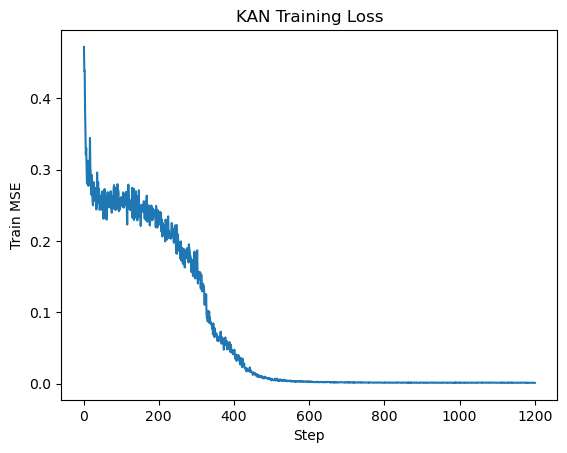

In [5]:
# Cell 5: Loss curve
plt.figure()
plt.plot(np.arange(1, len(train_losses)+1), train_losses)
plt.xlabel("Step")
plt.ylabel("Train MSE")
plt.title("KAN Training Loss")
plt.show()


Final validation MSE: 0.001119


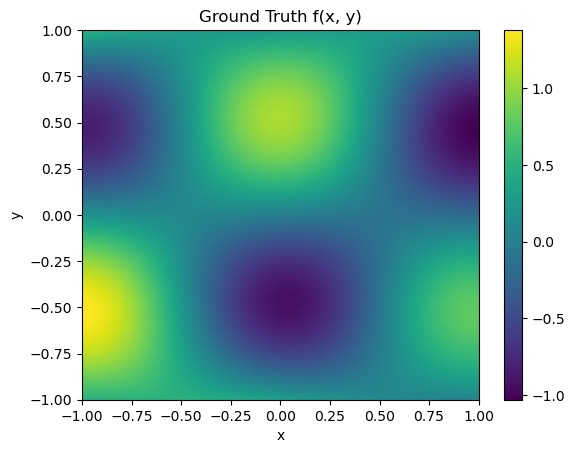

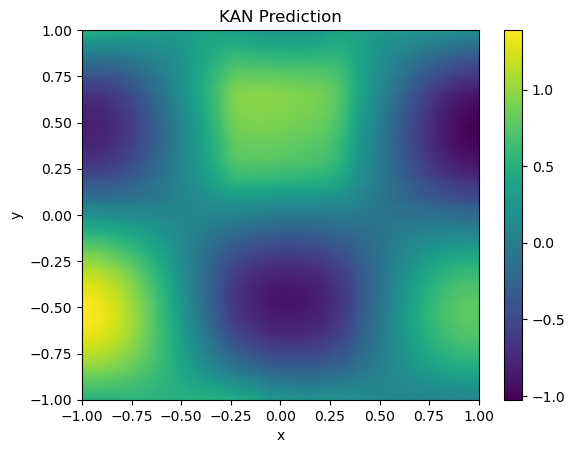

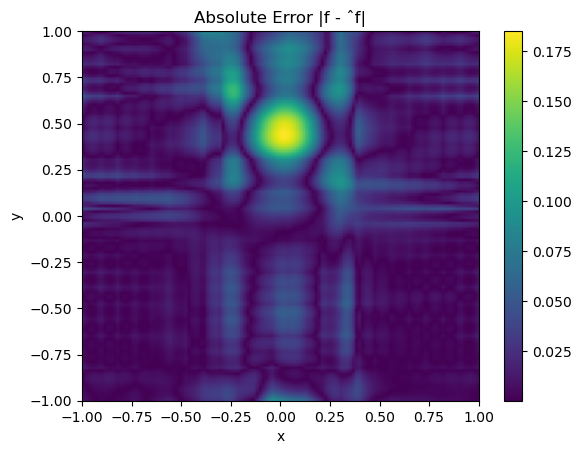

In [6]:
# Cell 6: Evaluation & visualizations

model.eval()
with torch.no_grad():
    pred_val = model(Xva)
    val_mse = F.mse_loss(pred_val, yva).item()

print(f"Final validation MSE: {val_mse:.6f}")

if DIM == 2:
    # Heatmaps on a grid
    N = 128
    xs = torch.linspace(DOMAIN[0], DOMAIN[1], steps=N)
    ys = torch.linspace(DOMAIN[0], DOMAIN[1], steps=N)
    Xg, Yg = torch.meshgrid(xs, ys, indexing="xy")
    XY = torch.stack([Xg.reshape(-1), Yg.reshape(-1)], dim=-1).to(DEVICE)

    with torch.no_grad():
        Z_true = target_function_2d(XY).reshape(N, N).cpu().numpy()
        Z_pred = model(XY).reshape(N, N).cpu().numpy()
        Z_err  = np.abs(Z_pred - Z_true)

    # Truth
    plt.figure()
    plt.imshow(
        Z_true.T, origin="lower",
        extent=[DOMAIN[0], DOMAIN[1], DOMAIN[0], DOMAIN[1]],
        aspect="auto",
    )
    plt.colorbar()
    plt.title("Ground Truth f(x, y)")
    plt.xlabel("x"); plt.ylabel("y")
    plt.show()

    # Prediction
    plt.figure()
    plt.imshow(
        Z_pred.T, origin="lower",
        extent=[DOMAIN[0], DOMAIN[1], DOMAIN[0], DOMAIN[1]],
        aspect="auto",
    )
    plt.colorbar()
    plt.title("KAN Prediction")
    plt.xlabel("x"); plt.ylabel("y")
    plt.show()

    # Absolute Error
    plt.figure()
    plt.imshow(
        Z_err.T, origin="lower",
        extent=[DOMAIN[0], DOMAIN[1], DOMAIN[0], DOMAIN[1]],
        aspect="auto",
    )
    plt.colorbar()
    plt.title("Absolute Error |f - \u02C6f|")
    plt.xlabel("x"); plt.ylabel("y")
    plt.show()

elif DIM == 1:
    # 1D curves: truth vs prediction
    with torch.no_grad():
        xs = torch.linspace(DOMAIN[0], DOMAIN[1], steps=600, device=DEVICE).unsqueeze(-1)
        y_true = target_function_1d(xs).cpu().numpy().reshape(-1)
        y_pred = model(xs).cpu().numpy().reshape(-1)
        x_np = xs.cpu().numpy().reshape(-1)

    # Truth curve
    plt.figure()
    plt.plot(x_np, y_true, label="truth")
    plt.xlabel("x"); plt.ylabel("f(x)")
    plt.title("Ground Truth f(x)")
    plt.show()

    # Prediction curve
    plt.figure()
    plt.plot(x_np, y_pred, label="KAN pred")
    plt.xlabel("x"); plt.ylabel("f̂(x)")
    plt.title("KAN Prediction")
    plt.show()

    # Error curve
    plt.figure()
    plt.plot(x_np, np.abs(y_true - y_pred), label="abs error")
    plt.xlabel("x"); plt.ylabel("|f - f̂|")
    plt.title("Absolute Error")
    plt.show()
